In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import confusion_matrix  #, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.datasets import make_classification

from scipy.stats import multivariate_normal, bernoulli

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp


import os
import sys

# Data Generation

In [2]:
# ===================== Binary classification =====================================================
def generate_data(m=100, n=20, signal=1, sigma=1, num_support=8, seed=1):
    "Generates data matrix X and observations Y."
    np.random.seed(seed)
    # beta_star = np.random.randn(n)
    # beta_star[num_support:] = 0
        
    beta_star = np.zeros(n)
    beta_star[:num_support] = signal
    X = np.random.randn(m,n)
    logits = X.dot(beta_star) # + np.random.normal(0, sigma, size=m)   # 误差加在这结果会好一些
    p = 1 / (1 + np.exp(-logits))                                    # 误差如果加在这，就会出现一些问题，p和x的关系就会被破坏
    Y = (p > 0.5).astype(int)
    return X, Y, beta_star, np.diag(np.ones(n))


# ===================== Multi-class classification =====================================================
def multi_classes(n_samples, n_features, n_informative, n_redundant, n_repeated, n_classes, seed=1):
    X, Y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative, 
                               n_redundant=n_redundant,
                               n_repeated = n_repeated,
                               n_classes=n_classes, 
                               shuffle=False, random_state=seed)
    return X, Y

n_informative = 8
n_redundant = 0
n_repeated = 0
n_classes = 5
num_support = n_informative + n_redundant

# Architecture

In [3]:
# ==============================================================================================
def get_data(x, y, batch_size=32):
#     x = StandardScaler(with_mean=True, with_std=True).fit_transform(x)
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :], y[idx, np.newaxis]



class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        '''
        obs_dim: dim_x or (dim_x + dim_y)
        action_dim: dim_x
        '''
        super(Actor, self).__init__()
        
        
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc2 = nn.Linear(256, action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Bernoulli(logits=logits)
        
        actions = m.sample()
        log_probs = m.log_prob(actions)
        entropy = m.entropy()
        
        return actions, log_probs, entropy




def compute_reward(X_train, Y_train, X_test, Y_test, actions, num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for action in actions.detach().numpy():
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
            classifier = MLPClassifier(hidden_layer_sizes=(128,), random_state=1, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3)
#             classifier = RandomForestClassifier(max_depth=5)
            classifier.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
#             probs = classifier.predict_proba(X_select)
#             eps = np.where(probs < 1e-4, 1e-4, 0)
#             log_probs = np.log(probs + eps)
#             log_likelihood = (log_probs[:, 1] * Y_test + log_probs[:, 0] * (1 - Y_test)).mean()
#             predict_proba = classifier.predict_proba(X_select)
#             loss = log_loss(Y_test, predict_proba)
#             dictionary[tuple(idx)] = loss
#             reward_list.append(loss)
            
#             classifier = RandomForestClassifier(max_depth=5)
#             classifier = SVC(gamma='auto')
            # classifier = LogisticRegression()
#             classifier.fit(X_select, Y_train)
            
#             X_select = X_test[:, idx] 
            score = classifier.score(X_select, Y_test)
            dictionary[tuple(idx)] = 1 - score
            reward_list.append(1 - score)
        
    return np.array(reward_list)

In [4]:
# training steps
m = 100
n = 24
sigma = 0.5
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=np.int)
y_true[:num_support] = 1


# # For multi-class classification
# n_informative = 8
# n_redundant = 0
# n_repeated = 0
# n_classes = 5
# num_support = n_informative + n_redundant



def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)
    # X, Y = generate_data(m, n, n_informative, n_redundant, n_repeated, n_classes, seed=seed)  
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    
    actor = Actor(obs_dim=n, action_dim=n)
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)

        
    action_select = []
    dictionary = dict()
    r_list = []
    
    r_baseline = torch.tensor(0)
    
    for step in range(200):
        # print('step: ', step)
        
        X_train, Y_train = get_data(x_train, y_train, batch_size=64)
        # obs = np.concatenate((X_train, Y_train), axis=1)    
        actions, log_probs, entropy = actor(X_train)
        action_select.append(actions.detach().numpy().mean(axis=0))
        
        # r_baseline = critic(X_train)
        # r_baseline = r_baseline.squeeze()
        
        
        rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=800, lr=1e-2, batch_size=64, dictionary=dictionary)
        r_list.append(rewards.mean())
        # print(f'average reward: {rewards.mean()}')
        rewards = torch.tensor(rewards, dtype=torch.float32)
        
        r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
        
        # update actor
        actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}')
        
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        # actor_optimizer.zero_grad()
        # actor_loss.backward()
        # actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}\n')
        
        # update critic
        # critic_loss = F.mse_loss(r_baseline, rewards)
        # critic_optimizer.zero_grad()
        # critic_loss.backward()
        # critic_optimizer.step()
        # print(f'critic loss: {critic_loss.item()}\n')
        
#         if step > 6:
#             if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
# #             print(f'converge at step {step}')
#                 break
    
    action_select = np.array(action_select)
            
    
    tmp = sorted(dictionary.items(), key=lambda x: x[1])
    s = set(range(n))
    for item in tmp[:10]:
        s = s & set(item[0])
    # print(s)
    
    with torch.no_grad():
        # obs = np.concatenate((X, Y[:, np.newaxis]), axis=1)
        actions, log_probs, _ = actor(X)
                        
#     y_pred_rl1 = np.where(action_select[-10:].mean(axis=0) >= 0.9, 1, 0)
#     y_pred_rl2 = np.where(actions.mean(dim=0) >= 0.9, 1, 0)
    y_pred_rl1 = action_select[-10:].mean(axis=0)
    y_pred_rl2 = actions.mean(dim=0).numpy()
    y_pred_rl3 = np.where([i in s for i in range(n)], 1, 0)
    
    
    logistic_cv = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', max_iter=1e6, solver='saga')
    logistic_cv.fit(X, Y)
    y_pred_logcv = np.where(logistic_cv.coef_.ravel() != 0, 1, 0)
#     logistic = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     logistic.fit(X, Y)
#     logistic_sfm = SelectFromModel(logistic, prefit=True)
#     y_pred_logsfm = np.where(logistic_sfm.get_support() != 0, 1, 0)
    rf = RandomForestClassifier(max_depth=5, random_state=seed)    
    rf.fit(X, Y)
    sfm = SelectFromModel(rf, prefit=True)
    y_pred_sfm = np.where(sfm.get_support() != 0, 1, 0)
    

    dat = np.vstack((y_pred_rl1, y_pred_rl2, y_pred_rl3, y_pred_logcv, y_pred_sfm))
    
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [5]:
if __name__ == '__main__':  
    # results = []
    # for sd in tqdm(range(20)):
    #     results.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))
    start = time.time()
    pool = mp.Pool(8)
    dats = pool.map(run, range(50))
    pool.close()
    end = time.time()
    print(datetime.timedelta(seconds = end - start))
    
    
    dats = np.array([dat for dat in dats])

random seed: 6 is runningrandom seed: 0 is runningrandom seed: 4 is runningrandom seed: 2 is runningrandom seed: 8 is runningrandom seed: 10 is runningrandom seed: 12 is runningrandom seed: 14 is running







rd: 14 take 0:20:36.416295
random seed: 15 is running
rd: 4 take 0:20:53.217901
random seed: 5 is running
rd: 0 take 0:20:57.234183
random seed: 1 is running
rd: 12 take 0:21:01.838768
random seed: 13 is running
rd: 2 take 0:21:05.202679
random seed: 3 is running
rd: 8 take 0:21:16.901707
random seed: 9 is running
rd: 10 take 0:21:29.460861
random seed: 11 is running
rd: 6 take 0:21:31.633976
random seed: 7 is running
rd: 15 take 0:20:11.903919
random seed: 16 is running
rd: 3 take 0:20:11.501849
random seed: 18 is running
rd: 1 take 0:20:38.642315
random seed: 20 is running
rd: 7 take 0:21:06.194252
random seed: 22 is running
rd: 9 take 0:21:29.418451
random seed: 24 is running
rd: 13 take 0:22:02.887634
random seed: 26 is running
rd: 11 take 0:21:57.787273
random seed: 28 is r

In [8]:
np.save('./synthetic_data_analysis/results/m100_n24_logistic_reg_coef1_actor_step200_1e-3_predictor_step800_lr1e-2_last10_predbz64_1.5h', dats)

In [3]:
dats = np.load('./synthetic_data_analysis/results/m100_n24_logistic_reg_coef1_actor_step200_1e-3_predictor_step800_lr1e-2_last10_predbz64_1.5h.npy')

In [4]:
m = 100
n = 24
sigma = 0.5
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=np.int)
y_true[:num_support] = 1

In [5]:
action_select = dats[:,0,:]
actions = dats[:,1,:]
y_pred_rl1 = np.where(action_select >= 0.9, 1, 0)
y_pred_rl2 = np.where(actions >= 0.9, 1, 0)
y_pred_rl3 = dats[:,2,:]
y_pred_logcv = dats[:,3,:]
y_pred_sfm = dats[:,4,:]


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
cm2 = [confusion_matrix(y_true, y) for y in y_pred_rl2]
cm3 = [confusion_matrix(y_true, y) for y in y_pred_rl3]
cm_logcv = [confusion_matrix(y_true, y) for y in y_pred_logcv]
cm_sfm = [confusion_matrix(y_true, y) for y in y_pred_sfm]





results = pd.DataFrame(np.zeros((4, 5)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm2, cm3, cm_logcv, cm_sfm]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['acp1', 'acp2', 'acp3', 'logcv', 'rf']

In [6]:
results

,acp1,acp2,acp3,logcv,rf
precision,0.877-0.102,0.863-0.104,0.887-0.135,1.000-0.000,1.000-0.000
recall,0.868-0.113,0.872-0.129,0.799-0.124,0.499-0.150,0.958-0.067
f1_score,0.869-0.091,0.862-0.100,0.830-0.102,0.654-0.123,0.977-0.037
specificity,0.927-0.067,0.927-0.083,0.875-0.092,0.421-0.261,0.975-0.041


# one run

In [4]:
start = time.time()
# training steps
m = 200
n = 50
signal = 1
sigma = 0.5
num_support = 8

# n_informative = 8
# n_redundant = 2
# n_classes = 5
# num_support = n_informative

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)
# X, Y = generate_data(m, n, n_informative, n_redundant, n_classes, seed=seed)  
      

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

actor = Actor(obs_dim=n, action_dim=n)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行
# critic = Critic(obs_dim=n)
# critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)



action_select = []
dictionary = dict()
r_list = []

r_baseline = torch.tensor(0)

for step in range(150):
    print('step: ', step)
    
    X_train, Y_train = get_data(x_train, y_train, batch_size=64)
#     obs = np.concatenate((X_train, Y_train), axis=1)
    actions, log_probs, entropy = actor(X_train)
    action_select.append(actions.detach().numpy().mean(axis=0))
    
    # r_baseline = critic(X_train)
    # r_baseline = r_baseline.squeeze()
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=800, lr=1e-2, batch_size=64, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
    rewards = torch.tensor(rewards, dtype=torch.float32)
    
    r_baseline = 0.95 * r_baseline + 0.05 *rewards.mean()
    
    # update actor
    actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()       # retain_graph=True if critic is used
    actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}')
    
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    # actor_optimizer.zero_grad()
    # actor_loss.backward()
    # actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}\n')
    
    # update critic
    # critic_loss = F.mse_loss(r_baseline, rewards)
    # critic_optimizer.zero_grad()
    # critic_loss.backward()
    # critic_optimizer.step()
    # print(f'critic loss: {critic_loss.item()}\n')
    # if step > 6:
    #     if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
    #         & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #         print(f'converge at step {step}')
    #         break

end = time.time()

print(datetime.timedelta(seconds=end - start))

step:  0
average reward: 0.30234375
step:  1
average reward: 0.28984375000000007
step:  2
average reward: 0.3065104166666667
step:  3
average reward: 0.2838541666666667
step:  4
average reward: 0.2885416666666667
step:  5
average reward: 0.29453124999999997
step:  6
average reward: 0.2677083333333333
step:  7
average reward: 0.2828125
step:  8


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training in

Traceback (most recent call last):
  File "D:\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-86b55e84abee>", line 49, in <module>
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=800, lr=1e-2, batch_size=64, dictionary=dictionary)
  File "<ipython-input-3-29d802fee3a0>", line 51, in compute_reward
    classifier.fit(X_select, Y_train)
  File "D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 406, in _fit
    self._random_state = check_random_state(self.random_state)
  File "D:\miniconda3\lib\site-packages\sklearn\utils\validation.py", line 1057, in check_random_state
    return np.random.RandomState(seed)
  File "mtrand.pyx", line 184, in numpy.rand

TypeError: object of type 'NoneType' has no len()

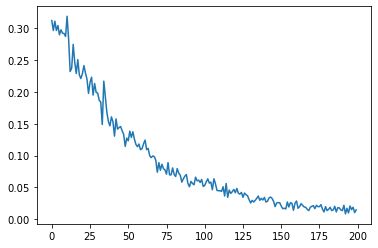

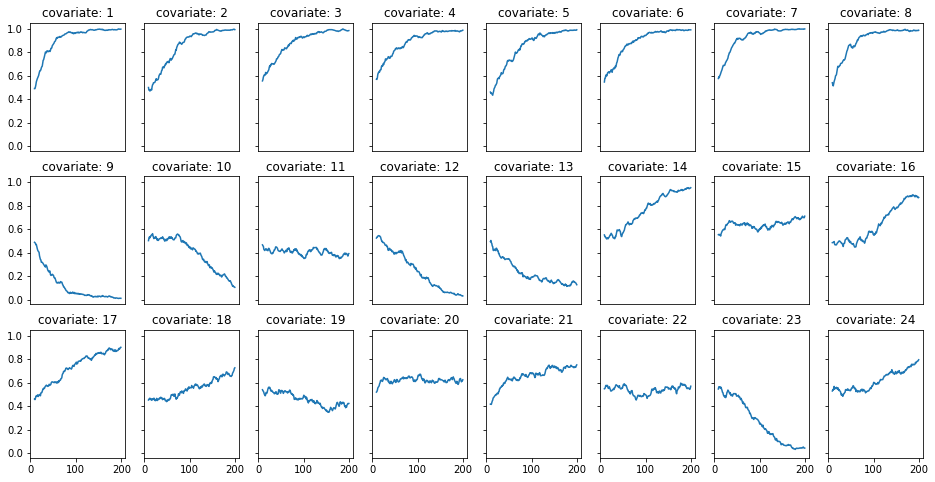

In [8]:
plt.figure()
plt.plot(r_list)
# plt.xlim(0, 1000)
# plt.ylabel('Mean Square Error')
# plt.yticks([12, 20, 40, 60, 80, 100, 120])
# plt.hlines(12, 0, 1000, color='r')


# print(np.where(beta_star != 0)[0] + 1)
# print(beta_star[:8])
action_select = np.array(action_select)

fig, axes = plt.subplots(int(n/8), 8, figsize=(16, 8), sharex=False, sharey=True)
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# fig.tight_layout()
num = 0
for i in range(int(n/8)):
    for j in range(8):
        axes[i, j].plot(pd.Series(action_select[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'covariate: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1

# natural policy gradient

In [5]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = LinearRegression(fit_intercept=False)
#             reg_clf = Ridge(alpha=0.05)
            # reg_clf = RandomForestRegressor(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesRegressor(n_estimators=50, max_depth=5)
            reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomClassifier(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesClassifier(n_estimators=50, max_depth=5)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [6]:
start = time.time()
# training steps
m = 200
n = 50
signal = 1
sigma = 0.5
num_support = 8
batch_size = 64

seed = 40
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)
# X, Y = multi_classes(m, n, n_informative, n_redundant, n_repeated, n_classes, seed=seed)  

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


# actor = Actor(obs_dim=n, action_dim=n)
# actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行



r_list = []
r_baseline = 0
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []

for step in range(150):                          # feature = 50, 150,    # feature = 300, >450, 但300似乎就把把正确的筛出来了, 用400
    print('step: ', step)
    
    p_list.append(theta)
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
        if action.sum == 0:
            idx = np.random.randint(0, n, int(n/3))
            action[idx] = 1
        actions[i, :] = action.numpy()
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size=batch_size, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)
    
    r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
    
    # sampled natural policy gradient
    log_pi_grad = actions / p - (1 - actions)/(1 - p)
    log_pi_grad = log_pi_grad.numpy()
    
    reg = Ridge(alpha=0.1)
    reg.fit(log_pi_grad, rewards)
    w = reg.coef_
    
    w_norm.append(np.linalg.norm(w))
    
    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

    if np.linalg.norm(theta - p_list[-1]) < 1e-3:
        print(f'converge at step {step}')
        break

end = time.time()

print(datetime.timedelta(seconds=end - start))

step:  0
average reward: 0.7218749999999999
step:  1
average reward: 0.7096354166666667
step:  2
average reward: 0.7354166666666667
step:  3
average reward: 0.7278645833333333
step:  4
average reward: 0.7221354166666667
step:  5
average reward: 0.7307291666666667
step:  6
average reward: 0.7380208333333333
step:  7
average reward: 0.7276041666666666
step:  8
average reward: 0.7377604166666667
step:  9
average reward: 0.7643229166666666
step:  10
average reward: 0.7611979166666667
step:  11
average reward: 0.7424479166666667
step:  12
average reward: 0.7484375
step:  13
average reward: 0.7588541666666666
step:  14
average reward: 0.7736979166666667
step:  15
average reward: 0.7614583333333333
step:  16
average reward: 0.7885416666666667
step:  17
average reward: 0.7856770833333333
step:  18
average reward: 0.7815104166666667
step:  19
average reward: 0.7927083333333333
step:  20
average reward: 0.79140625
step:  21
average reward: 0.79375
step:  22
average reward: 0.7971354166666667
ste

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


average reward: 0.8447916666666666
step:  55


KeyboardInterrupt: 

[0.98 0.76 0.98 0.73 0.89 0.91 0.96 0.7  0.56 0.54 0.51 0.42 0.34 0.5
 0.52 0.38 0.47 0.4  0.72 0.45 0.53 0.5  0.51 0.48 0.53 0.54 0.49 0.43
 0.41 0.39 0.51 0.51 0.49 0.48 0.53 0.56 0.45 0.49 0.49 0.57 0.43 0.5
 0.6  0.57 0.43 0.52 0.46 0.38 0.42 0.55 0.48 0.52 0.32 0.51 0.52 0.5
 0.48 0.49 0.33 0.72 0.47 0.5  0.38 0.48 0.42 0.5  0.45 0.48 0.44 0.44
 0.51 0.43 0.55 0.5  0.48 0.46 0.42 0.47 0.56 0.62 0.53 0.5  0.53 0.59
 0.47 0.48 0.49 0.38 0.66 0.44 0.51 0.47 0.53 0.49 0.54 0.48 0.54 0.55
 0.53 0.5  0.49 0.58 0.53 0.84 0.39 0.43 0.48 0.5  0.31 0.54 0.45 0.44
 0.48 0.5  0.67 0.49 0.53 0.53 0.42 0.44 0.47 0.49 0.33 0.51 0.49 0.54
 0.61 0.5  0.52 0.55 0.58 0.46 0.49 0.4  0.53 0.45 0.3  0.53 0.41 0.44
 0.47 0.5  0.51 0.49 0.48 0.46 0.51 0.53 0.51 0.53 0.31 0.74 0.68 0.47
 0.49 0.49 0.52 0.34 0.44 0.42 0.4  0.42 0.52 0.47 0.41 0.54 0.53 0.38
 0.47 0.37 0.52 0.51 0.54 0.56 0.39 0.48 0.43 0.52 0.49 0.19 0.43 0.41
 0.4  0.43 0.51 0.53 0.46 0.54 0.43 0.5  0.34 0.5  0.26 0.39 0.51 0.52
 0.51 0.5

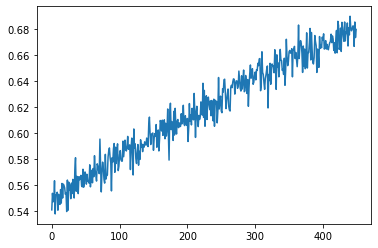

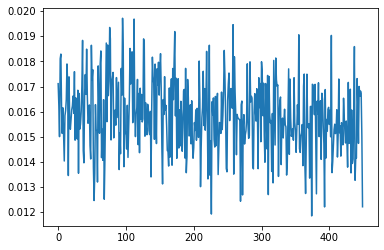

In [35]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.90)[0])
print(np.argsort(theta)[::-1])
plt.figure()
plt.plot(w_norm)

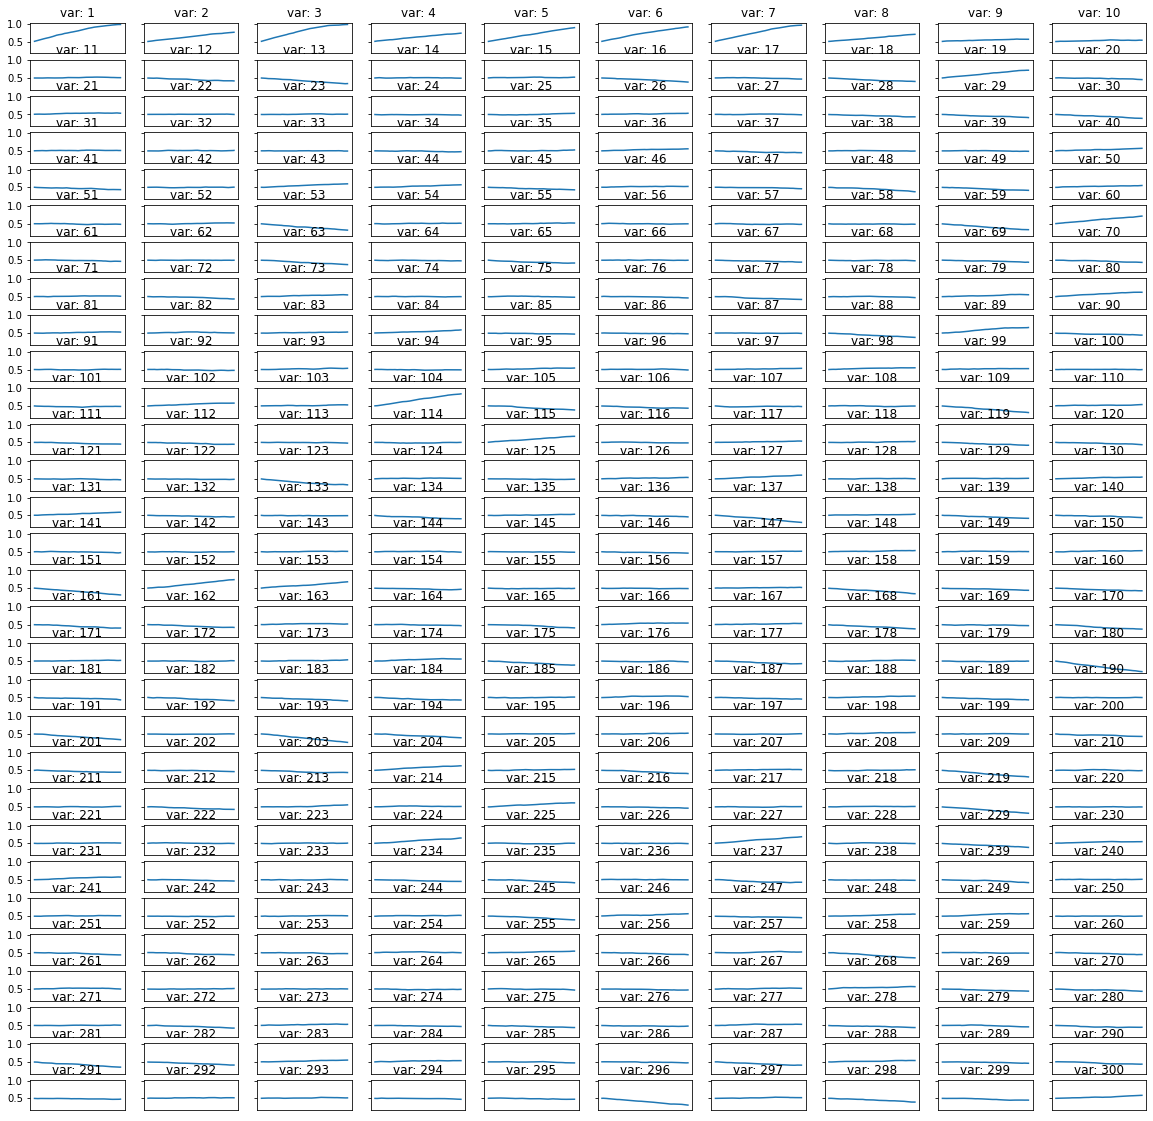

In [37]:
probs = np.array(p_list)
fig, axes = plt.subplots(int(n/10+0.9), 10, figsize=(20, 20), sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(int(n/10+0.9)):
    for j in range(10):
        axes[i, j].plot(pd.Series(np.array(probs)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1

In [10]:
print('npg')
print(np.where(theta > 0.90)[0] + 1)

print('logistic_cv')
logistic_cv = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', max_iter=1e6, solver='saga')
logistic_cv.fit(X, Y)
print(np.where(logistic_cv.coef_[0] != 0)[0] + 1)

print('random_forest')
rf = RandomForestClassifier(max_depth=5, random_state=seed)    
rf.fit(X, Y)
sfm = SelectFromModel(rf, prefit=True)
print(np.arange(n)[sfm.get_support()] + 1)

npg
[2 3 4 6 7 8]
logistic_cv
[ 1  3  4  6  7  9 12 13 14 15 18 19 22 25 30]
random_forest
[1 2 3 4 6 7 8]


In [36]:
num_selected = 8

npg = np.argsort(theta)[::-1][:num_selected]
print('npg: ', np.sort(npg))


print('logistic_cv')
logistic_cv = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', max_iter=1e6, solver='saga')
logistic_cv.fit(X, Y)
print('logistic_cv: ', np.where(logistic_cv.coef_[0] != 0)[0])

regr = RandomForestClassifier(max_depth=5)
regr.fit(x_train, y_train)
rf = np.argsort(regr.feature_importances_)[::-1][:num_selected]
print('random_forest: ', np.sort(rf))

npg:  [  0   1   2   4   5   6 103 151]
logistic_cv
logistic_cv:  [  0   1   2   3   4   5   6   7  17  25  35  45  49  52  53  56  59  60
  67  83  92  94  99 101 103 107 111 114 126 130 134 142 147 151 152 166
 186 203 211 214 218 226 229 247 266 284 299]
random_forest:  [  0   2   3   4   6  45 126 174]


## run different seeds

In [24]:
# training steps
m = 200
n = 50
sigma = 0.5
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=int)
y_true[:num_support] = 1
batch_size = 64

def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
#     X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)   
    X, Y = multi_classes(m, n, n_informative, n_redundant, n_repeated, n_classes, seed=seed) 
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    
    
        
    r_list = []
    r_baseline = 0
    dictionary = dict()
    theta = np.zeros(n) + 0.5
    p_list = []
#     w_norm = []
    
    for step in range(200):
        # print('step: ', step)
        
        p_list.append(theta)
        actions = np.zeros((batch_size, n))
        p = torch.from_numpy(theta)
        for i in range(batch_size):
            action = torch.bernoulli(p)
            if action.sum() == 0:
                idx = np.random.randint(0, n, int(n/3))
                action[idx] = 1
            actions[i, :] = action.numpy()



        rewards = compute_reward(x_train, y_train, x_test, y_test, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size=batch_size, dictionary=dictionary)
        r_list.append(rewards.mean())
#         print(f'average reward: {rewards.mean()}')
    #     rewards = torch.tensor(rewards, dtype=torch.float32)

        # r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()

        # sampled natural policy gradient
        log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


        reg = Ridge(alpha=0.1)
        reg.fit(log_pi_grad, rewards)
        w = reg.coef_

#         w_norm.append(np.linalg.norm(w))

        theta = theta + 1 * w    
        theta = np.clip(theta, 0.02, 0.98)


    #     if step > 6:
    #         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
    #             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #             print(f'converge at step {step}')
    #             break

        if np.linalg.norm(theta - p_list[-1]) < 1e-3:
            print(f'converge at step {step}')
            break
            
    
#     tmp = sorted(dictionary.items(), key=lambda x: x[1])
#     s = set(range(n))
#     for item in tmp[:10]:
#         s = s & set(item[0])
    # print(s)
    
                        
#     y_pred_rl1 = np.where(action_select[-10:].mean(axis=0) >= 0.9, 1, 0)
#     y_pred_rl2 = np.where(actions.mean(dim=0) >= 0.9, 1, 0)
#     y_pred_rl1 = action_select[-10:].mean(axis=0)
#     y_pred_rl2 = actions.mean(dim=0).numpy()
    y_pred_rl1 = theta
#     y_pred_rl3 = np.where([i in s for i in range(n)], 1, 0)
    
    
    logistic_cv = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', max_iter=1e6, solver='saga')
    logistic_cv.fit(x_train, y_train)
    y_pred_logcv = logistic_cv.coef_[0]
    rf = RandomForestClassifier(max_depth=5)
    rf.fit(x_train, y_train)
    y_pred_rf = rf.feature_importances_
    
    dat = np.vstack((y_pred_rl1, y_pred_logcv, y_pred_rf))
    
    print('npg', np.argsort(theta)[::-1][:8])
    print('logistic cv', np.argsort(y_pred_logcv)[::-1][:8])
    print('random forest', np.argsort(y_pred_rf)[::-1][:8])
    
    # cm1 = confusion_matrix(y_true, y_pred_rl1)
    # cm2 = confusion_matrix(y_true, y_pred_rl2)
    # cm_bic = confusion_matrix(y_true, y_pred_bic)
    # cm_aic = confusion_matrix(y_true, y_pred_aic)
    # # return cm1, cm2, cm_bic, cm_aic
    
    # dat = pd.DataFrame(np.zeros((3, 4)), index=['precision', 'specificity', 'recall'])
    #                     # columns=['cm1', 'cm2', 'bic', 'aic'])
    
    # for i, cm in enumerate([cm1, cm2, cm_bic, cm_aic]):
    #     tn, fp, fn, tp = cm.ravel()
    #     dat.loc['precision', i] = tp/(tp+fn)
    #     dat.loc['specificity', i] = tn/(tn+fp)
    #     dat.loc['recall', i] = 0 if tp + fp == 0 else tp/(tp+fp)
        
    # dat.columns = ['cm1', 'cm2', 'bic', 'aic']
    
    
#     regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     regr.fit(X, Y)
#     sfm = SelectFromModel(regr, prefit=True)
#     y_pred_log = np.where(sfm.get_support(), 1, 0)
    
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [25]:
if __name__ == '__main__':
    start = time.time()
    dats = []
    for sd in tqdm(range(50)):
        dats.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))

#     pool = mp.Pool(5)
#     dats = pool.map(run, range(50))
#     pool.close()
    end = time.time()
    print(datetime.timedelta(seconds = end - start))
    
    
    dats = np.array([dat for dat in dats])

  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

random seed: 0 is running


  2%|███▎                                                                                                                                                                   | 1/50 [12:13<9:59:20, 733.90s/it]

npg [ 0  2  3  4  7  1 21 46]
logistic cv [34 26  4 47  0 46 13  3]
random forest [ 2  1  4  7  0  5  6 34]
rd: 0 take 0:12:13.880818
random seed: 1 is running


  4%|██████▋                                                                                                                                                                | 2/50 [24:17<9:42:26, 728.06s/it]

npg [ 4  5  7  3  6  0  9 10]
logistic cv [ 5 36 29 15 34  6 47 30]
random forest [ 4  7  0  3  5  1  6 24]
rd: 1 take 0:12:03.952692
random seed: 2 is running


  6%|██████████                                                                                                                                                             | 3/50 [37:35<9:55:03, 759.65s/it]

npg [ 6  4  0  5  2  1  3 15]
logistic cv [49 12 22 21 20 19 18 17]
random forest [ 6  2  0  5  1  3 32 30]
rd: 2 take 0:13:17.225562
random seed: 3 is running


  8%|█████████████▎                                                                                                                                                         | 4/50 [50:05<9:39:35, 755.98s/it]

npg [ 2  3  5  0  6  1 49 20]
logistic cv [ 3 31 49 47 15 37 43 42]
random forest [ 5  2  6  3  7  0  4 40]
rd: 3 take 0:12:30.325468
random seed: 4 is running


 10%|████████████████▌                                                                                                                                                    | 5/50 [1:02:43<9:27:36, 756.82s/it]

npg [17  7  2  3  5  4  6  9]
logistic cv [49 12 22 21 20 19 18 17]
random forest [5 2 3 7 4 6 0 1]
rd: 4 take 0:12:38.268228
random seed: 5 is running


 12%|███████████████████▊                                                                                                                                                 | 6/50 [1:15:22<9:15:25, 757.39s/it]

npg [ 0  3  7  6 31  5  2 43]
logistic cv [30 25  3 11 22 14 16  4]
random forest [ 3  7  0  5 28  4  2  6]
rd: 5 take 0:12:38.456901
random seed: 6 is running


 14%|███████████████████████                                                                                                                                              | 7/50 [1:28:23<9:08:21, 765.15s/it]

npg [ 2  3  4  7  6  0 41 10]
logistic cv [27 40  7 10 13 15 37 19]
random forest [ 7  1  4  2 46  3 10 40]
rd: 6 take 0:13:01.077754
random seed: 7 is running


 16%|██████████████████████████▍                                                                                                                                          | 8/50 [1:41:42<9:03:09, 775.94s/it]

npg [1 2 4 5 7 6 0 3]
logistic cv [14 23 20  9 26 18  0 48]
random forest [ 0  3  5  7  2  6 14  1]
rd: 7 take 0:13:19.030157
random seed: 8 is running


 18%|█████████████████████████████▎                                                                                                                                     | 9/50 [3:16:24<26:18:22, 2309.82s/it]

npg [0 1 3 4 2 6 5 7]
logistic cv [ 7 21  3  8 49 36 26 17]
random forest [ 5  2  4  1 13  0  7  3]
rd: 8 take 1:34:42.513633
random seed: 9 is running


 20%|████████████████████████████████▍                                                                                                                                 | 10/50 [3:28:14<20:10:26, 1815.66s/it]

npg [ 0  1  2  7  4  6  3 13]
logistic cv [39 33 34 14 22 13  9  0]
random forest [ 0  2  3  5  6  1 35 27]
rd: 9 take 0:11:49.124776
random seed: 10 is running


 22%|███████████████████████████████████▋                                                                                                                              | 11/50 [3:40:48<16:09:08, 1490.98s/it]

npg [ 2  4  6  3  1  5  7 49]
logistic cv [39  4  1 37 30 44 18  2]
random forest [ 1  6  4  3  5 39  7 28]
rd: 10 take 0:12:34.771408
random seed: 11 is running


 24%|██████████████████████████████████████▉                                                                                                                           | 12/50 [3:53:54<13:28:25, 1276.45s/it]

npg [ 2  4  6  7  0  1 32  5]
logistic cv [38  4 40 17  5  7 42 33]
random forest [ 4  7  5  1  0  3 21 38]
rd: 11 take 0:13:05.765196
random seed: 12 is running


 26%|██████████████████████████████████████████                                                                                                                        | 13/50 [4:06:25<11:28:57, 1117.23s/it]

npg [ 7  2  3  5  1  6  0 10]
logistic cv [49 12 22 21 20 19 18 17]
random forest [ 6  0  3  2  7  1 29 47]
rd: 12 take 0:12:30.855060
random seed: 13 is running


 28%|█████████████████████████████████████████████▉                                                                                                                      | 14/50 [4:18:22<9:57:43, 996.22s/it]

npg [4 7 5 0 3 6 2 1]
logistic cv [ 8 22 41  1 15 28 40 43]
random forest [ 7  5  6  1 44 37  2 45]
rd: 13 take 0:11:56.553682
random seed: 14 is running


 30%|█████████████████████████████████████████████████▏                                                                                                                  | 15/50 [4:30:03<8:49:17, 907.35s/it]

npg [0 3 6 7 1 2 5 4]
logistic cv [ 2 38 33 32 13 49  8 16]
random forest [ 3  4  6  1  2  5  7 38]
rd: 14 take 0:11:41.386197
random seed: 15 is running


 32%|████████████████████████████████████████████████████▍                                                                                                               | 16/50 [4:41:38<7:57:59, 843.52s/it]

npg [ 3  0  7  1 22  6  5 10]
logistic cv [ 1  0 12 22 21 20 19 18]
random forest [ 7  3  1  0  6  4 30 33]
rd: 15 take 0:11:35.274241
random seed: 16 is running


 34%|███████████████████████████████████████████████████████▊                                                                                                            | 17/50 [4:53:14<7:19:27, 799.02s/it]

npg [ 1  3  4  7  2  0  5 42]
logistic cv [12 10 30 29  1 24  5  9]
random forest [ 1  0  4  3  2  7  6 24]
rd: 16 take 0:11:35.522462
random seed: 17 is running


 36%|███████████████████████████████████████████████████████████                                                                                                         | 18/50 [5:04:41<6:48:14, 765.45s/it]

npg [ 0  2  3  6 23 45 21 19]
logistic cv [ 0 18 29  4 33 30 16 39]
random forest [ 0  3  2  6  7  4  1 10]
rd: 17 take 0:11:27.289203
random seed: 18 is running


 38%|██████████████████████████████████████████████████████████████▎                                                                                                     | 19/50 [5:16:16<6:24:28, 744.16s/it]

npg [ 0  5  2  1 39  7  6 27]
logistic cv [44 10 38 41  4  7  3 16]
random forest [ 2  7  5  4  0 44  6 39]
rd: 18 take 0:11:34.519628
random seed: 19 is running


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 20/50 [5:27:38<6:02:45, 725.52s/it]

npg [ 0  2  7  5  4  3 15 41]
logistic cv [49 12 22 21 20 19 18 17]
random forest [ 4  2  7  0  3 41  5 43]
rd: 19 take 0:11:22.066727
random seed: 20 is running


 42%|████████████████████████████████████████████████████████████████████▉                                                                                               | 21/50 [5:39:20<5:47:19, 718.61s/it]

npg [ 5  1  7  2  6  0  4 48]
logistic cv [ 2  6 49 13 22 21 20 19]
random forest [ 1  2  5 44 25  7  6 38]
rd: 20 take 0:11:42.463499
random seed: 21 is running


 44%|████████████████████████████████████████████████████████████████████████▏                                                                                           | 22/50 [5:51:15<5:34:50, 717.51s/it]

npg [0 4 7 3 6 5 1 2]
logistic cv [ 4  3  7 45 28  6 32 49]
random forest [ 7  0  4  1  3 29 32 16]
rd: 21 take 0:11:54.920685
random seed: 22 is running


 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                        | 23/50 [6:02:36<5:17:58, 706.62s/it]

npg [ 6 43  1  7  3  0  2 12]
logistic cv [ 0 48 22 21 20 19 18 17]
random forest [ 6  3  0  7  1 19 38 27]
rd: 22 take 0:11:21.215373
random seed: 23 is running


 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                    | 24/50 [6:32:13<7:25:16, 1027.55s/it]

npg [ 1  6  3  0  2  4  5 18]
logistic cv [49 12 22 21 20 19 18 17]
random forest [ 0  2  3  4  6  7 17 45]
rd: 23 take 0:29:36.165829
random seed: 24 is running


 50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 25/50 [6:43:50<6:26:53, 928.55s/it]

npg [ 7  1  2  6  3 49  5 37]
logistic cv [ 1 49 12 22 21 20 19 18]
random forest [ 1  6  7  4  0 28 31 39]
rd: 24 take 0:11:37.554070
random seed: 25 is running


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 26/50 [6:56:26<5:50:39, 876.66s/it]

npg [1 5 7 6 4 0 3 2]
logistic cv [ 6 49 12 22 21 20 19 18]
random forest [ 6  1  4 21  0 35 48 31]
rd: 25 take 0:12:35.559154
random seed: 26 is running


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 27/50 [7:08:07<5:15:52, 824.01s/it]

npg [ 4 24  1  3  2  5  6  0]
logistic cv [ 6  5 45  3  7 32 48 30]
random forest [ 3  5  4 40  0  7  6 27]
rd: 26 take 0:11:41.150520
random seed: 27 is running


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 28/50 [7:20:05<4:50:31, 792.33s/it]

npg [1 2 6 7 5 0 4 3]
logistic cv [36 15 13 28  7 17  1 46]
random forest [ 6  2  3  0 47 19  4 42]
rd: 27 take 0:11:58.390301
random seed: 28 is running


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 29/50 [15:04:49<52:02:00, 8920.03s/it]

npg [14  6  4  2  1  7 24  5]
logistic cv [ 0 21  3  5 29 16 23 22]
random forest [ 2  4  7  6  0  1 14  3]
rd: 28 take 7:44:43.729376
random seed: 29 is running


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 30/50 [15:21:47<36:23:04, 6549.25s/it]

npg [2 6 4 3 7 5 1 0]
logistic cv [21  2 30  3 31 42 27  1]
random forest [ 4  6  1 32  3  5 35 31]
rd: 29 take 0:16:57.540798
random seed: 30 is running


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 31/50 [15:35:30<25:29:58, 4831.52s/it]

npg [ 5  1  3  0  2  6 17 33]
logistic cv [ 6  0 12 22 21 20 19 18]
random forest [ 1  6  5  0  2 47  3 12]
rd: 30 take 0:13:43.519649
random seed: 31 is running


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 32/50 [15:49:03<18:07:43, 3625.77s/it]

npg [ 0  4  2  3  5 37 46  1]
logistic cv [47 18  7 31 41 46  6 49]
random forest [ 3  2  0  4  1  6  5 47]
rd: 31 take 0:13:32.321596
random seed: 32 is running


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 33/50 [16:01:17<13:01:32, 2758.39s/it]

npg [ 7  1  2  5  6 22  4 33]
logistic cv [ 2  9 26 23 46 11  3 40]
random forest [ 6  5  1  2 38  4 22 27]
rd: 32 take 0:12:14.459084
random seed: 33 is running


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 34/50 [16:13:10<9:31:56, 2144.80s/it]

npg [ 0  3  4  6  7  5  1 17]
logistic cv [ 1 15 27 35 29 38 49 14]
random forest [ 7  1  0  6  3 34 45  4]
rd: 33 take 0:11:53.105282
random seed: 34 is running


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 35/50 [16:25:06<7:09:01, 1716.11s/it]

npg [1 3 4 5 7 6 2 0]
logistic cv [ 1 39  2 33 21 23 27 42]
random forest [4 0 7 6 2 5 1 3]
rd: 34 take 0:11:55.804759
random seed: 35 is running


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 36/50 [16:37:39<5:33:01, 1427.24s/it]

npg [ 4  3  0  1  6  5  8 42]
logistic cv [ 6 33 49 42  1  3 37  4]
random forest [ 1 38  4  6 42  7 24 19]
rd: 35 take 0:12:33.154945
random seed: 36 is running


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 37/50 [16:49:49<4:23:51, 1217.80s/it]

npg [ 5  7  3  6  2  0  4 22]
logistic cv [49 12 22 21 20 19 18 17]
random forest [ 3  7  4 21  5  0  1 43]
rd: 36 take 0:12:09.069692
random seed: 37 is running


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 38/50 [17:01:35<3:32:53, 1064.43s/it]

npg [ 7  4  3  2  6  1  5 30]
logistic cv [ 3 12 29  7  1 40 16  2]
random forest [ 7  2  5  3  6  4  0 14]
rd: 37 take 0:11:46.555879
random seed: 38 is running


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 39/50 [17:14:30<2:59:12, 977.49s/it]

npg [ 0  7  2  3  4  1  5 49]
logistic cv [30  7  6  9 21 20 38 44]
random forest [ 7  4  3  0  1  2 46 44]
rd: 38 take 0:12:54.571931
random seed: 39 is running


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 40/50 [17:27:16<2:32:21, 914.17s/it]

npg [ 4  7  0  1  6  3  2 18]
logistic cv [49 48 22 21 20 19 18 17]
random forest [ 0  3  7  5  6 32  1 19]
rd: 39 take 0:12:46.401878
random seed: 40 is running


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 41/50 [17:39:27<2:08:51, 859.04s/it]

npg [ 2  5  6  3 39 32  4  7]
logistic cv [33  4 40 26 39 46 16  7]
random forest [ 4  2  3  1 15  7  5 42]
rd: 40 take 0:12:10.380458
random seed: 41 is running


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 42/50 [17:52:09<1:50:39, 829.92s/it]

npg [ 6  7  2  5  0  1  4 47]
logistic cv [ 2 26 43  6 24 27 25 10]
random forest [ 2  7  5 37  0 40  3  4]
rd: 41 take 0:12:41.955790
random seed: 42 is running


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 43/50 [18:04:46<1:34:17, 808.19s/it]

npg [6 7 3 0 2 1 4 5]
logistic cv [23 19 32 37  2 46  0 27]
random forest [ 7 49  0  5  2  3  1  6]
rd: 42 take 0:12:37.462575
random seed: 43 is running


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 44/50 [18:18:27<1:21:12, 812.13s/it]

npg [0 1 6 7 5 2 3 4]
logistic cv [ 9 30  0 40 35  7 42 48]
random forest [ 1  6  2  0  7  5 28 47]
rd: 43 take 0:13:41.296755
random seed: 44 is running


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 45/50 [18:30:59<1:06:10, 794.11s/it]

npg [ 0 39  6  7  5  3  1  4]
logistic cv [ 3 32 12  7 47 36 16 14]
random forest [ 2  6  5  1  0 30 40  4]
rd: 44 take 0:12:32.011797
random seed: 45 is running


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 46/50 [18:43:50<52:28, 787.01s/it]

npg [1 2 6 5 3 7 4 0]
logistic cv [ 3 20 31  2 38 22 36 40]
random forest [ 4  2  6  7  1 17  3  0]
rd: 45 take 0:12:50.418363
random seed: 46 is running


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 47/50 [18:56:00<38:29, 769.94s/it]

npg [ 6  2  5  7  1  0  4 37]
logistic cv [28  9  5 44  2  4  3 19]
random forest [ 7  1  2  5  3  6 44 30]
rd: 46 take 0:12:10.096351
random seed: 47 is running


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 48/50 [19:08:44<25:36, 768.13s/it]

npg [ 4  7  6  5  1  0 23 20]
logistic cv [46 39 34 49 14 48 23 21]
random forest [ 2  6  5  1  4  3  7 13]
rd: 47 take 0:12:43.864080
random seed: 48 is running


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 49/50 [19:21:48<12:52, 772.86s/it]

npg [0 4 6 7 3 1 2 5]
logistic cv [ 0 28  7  4  3 38 48 40]
random forest [ 0  6  7 22  3 40 39  4]
rd: 48 take 0:13:03.864434
random seed: 49 is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [19:34:16<00:00, 1409.12s/it]

npg [ 0  4  7  2  6  1 26  9]
logistic cv [31 36 15 44  2 33 28  7]
random forest [ 7  0  2 26 10 22  4 44]
rd: 49 take 0:12:27.784496
19:34:16.142405


In [26]:
dats.shape

(50, 3, 50)

In [33]:
theta = dats[:,0,:]
indices = np.argsort(theta, axis=1)[:, -8:]
y_pred_rl1 = np.zeros((50, n))
for i, indice in enumerate(indices):
    y_pred_rl1[i, indice] = 1
    

y_pred_cv = np.zeros((50, n))
nums = np.sum(dats[:, 1, :] != 0, axis=1)
for i, num in enumerate(nums):
    if num < 8:
        idx = np.where(dats[i, 1, :] != 0)[0]
    else:
        idx = np.argsort(dats[i, 1, :])[-8:]
    y_pred_cv[i, idx] = 1    


indices = np.argsort(dats[:, 2, :], axis=1)[:, -8:]
y_pred_rf = np.zeros((50, n))
for i, indice in enumerate(indices):
    y_pred_rf[i, indice] = 1


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
cm_cv = [confusion_matrix(y_true, y) for y in y_pred_cv]
cm_rf = [confusion_matrix(y_true, y) for y in y_pred_rf]





results = pd.DataFrame(np.zeros((4, 3)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm_cv, cm_rf]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['npg', 'logistic cv', 'rf']

results

,npg,logistic cv,rf
precision,0.853-0.111,0.240-0.139,0.757-0.118
recall,0.853-0.111,0.388-0.316,0.757-0.118
f1_score,0.853-0.111,0.262-0.140,0.757-0.118
specificity,0.972-0.021,0.899-0.064,0.954-0.023


In [32]:
theta = dats[:,0,:]
y_pred_rl1 = np.where(theta > 0.85, 1, 0)


y_pred_cv = np.zeros((50, n))
nums = np.sum(dats[:, 1, :] != 0, axis=1)
for i, num in enumerate(nums):
    idx = np.where(dats[i, 1, :] != 0)[0]
    y_pred_cv[i, idx] = 1  


means = np.mean(dats[:, 2, :], axis=1)
y_pred_rf = np.zeros((50, n))
for i, mean in enumerate(means):
    y_pred_rf[i, :] =np.where(dats[i, 2, :] > mean, 1, 0)


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
cm_cv = [confusion_matrix(y_true, y) for y in y_pred_cv]
cm_rf = [confusion_matrix(y_true, y) for y in y_pred_rf]





results = pd.DataFrame(np.zeros((4, 3)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm_cv, cm_rf]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['npg', 'logistic cv', 'rf']

results

,npg,logistic cv,rf
precision,0.843-0.127,0.550-0.295,0.920-0.082
recall,0.857-0.123,0.391-0.303,0.488-0.087
f1_score,0.843-0.105,0.350-0.141,0.634-0.083
specificity,0.970-0.029,0.737-0.201,0.807-0.059


In [31]:
np.save('m200_n50_make_classification_step200_batch64_mlp_reward_19.5h.npy', dats)